In [7]:
COMPARISONS = ['P08_noDenoising', 'P08_LR8', 'P08_unet_JInvariant']

quality_clip = True # show voxels that meet LC Model quality criteria
outlier_clip = False
clip_pct = 2.0 # entfernt oberste 2% der fehlerpixl um außreißer zu vermeiden

In [ ]:
# import numpy as np 
# import matplotlib.pyplot as plt

# mask = np.load('mask.npy')
# mask = np.swapaxes(mask, 2,1)
# np.save('mask.npy',mask)

In [33]:
from cmcrameri import cm
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import Optional, List

def plot_metab_maps(
        metabolite: str,
        methods: List[str],
        quality_clip: bool = False,
        outlier_clip: bool = False,
        clip_pct: float | None = None,
        z: int = 13,
        data_dir: str = "MetabMaps",
        scale: str = 'global',      # 'auto' | 'global' | 'percentile'
        percentile: tuple[float, float] = (2, 98),
        row_titles: Optional[List[str]] = None,
        cmap = cm.batlow,
        title_fontsize: int = 13,
        title_fontweight: str = "bold",
        # --- Maske ---
        mask_file: Optional[str] = None,   # z.B. "mask.npy"
        mask_color: str = "white",
        mask_linewidth: float = 0.9,
        # schnelle Ausrichtungs-Schalter (falls gebraucht)
        mask_transpose: bool = False,
        mask_flipud: bool = False,
        mask_fliplr: bool = False,
        mask_rotate_k: int = 0            # 0,1,2,3 -> 0..270° (np.rot90)
    ) -> None:

    suffix = "OutlierClip" if outlier_clip else ("QualityClip" if quality_clip else "Orig")

    # AMP laden
    amps = {}
    for m in methods:
        fpath = os.path.join(data_dir, m, f"{metabolite}_amp_{m}_{suffix}.npy")
        if os.path.isfile(fpath):
            amps[m] = np.load(fpath)
        else:
            print(f"❌ AMP fehlt: {fpath}")
    if not amps:
        raise FileNotFoundError("Keine AMP-Dateien gefunden.")

    amp_slice = {k: v[z, ...] for k, v in amps.items()}  # (X, Y, T)
    T = next(iter(amps.values())).shape[-1]
    M = len(methods)

    # Skala
    all_imgs = np.stack(list(amp_slice.values()), axis=0)
    if scale == 'global':
        vmin = np.nanmin(all_imgs)
        vmax = np.nanmax(all_imgs)
    elif scale == 'percentile':
        vmin = np.nanpercentile(all_imgs, percentile[0])
        vmax = np.nanpercentile(all_imgs, percentile[1])
    else:
        vmin = vmax = None

    # Hintergrundfarbe = Colormap-Farbe für Wert 0
    if vmin is None or vmax is None or vmax == vmin:
        bg_color = cmap(0.0)
    else:
        norm0 = float(np.clip((0.0 - vmin) / (vmax - vmin), 0.0, 1.0))
        bg_color = cmap(norm0)

    # Zeilentitel
    if row_titles is None:
        row_titles = methods
    assert len(row_titles) == M

    # Maske laden & ggf. ausrichten
    mask = None
    if mask_file is not None and os.path.isfile(mask_file):
        mask = np.load(mask_file)
        if mask.ndim == 3:
            mask = mask[z, ...]
        if mask_rotate_k:
            mask = np.rot90(mask, k=mask_rotate_k)
        if mask_transpose:
            mask = mask.T
        if mask_flipud:
            mask = np.flipud(mask)
        if mask_fliplr:
            mask = np.fliplr(mask)
        mask = mask.astype(bool)

    # Grid
    label_col_width = 0.12
    plot_cols = T
    total_cols = 1 + plot_cols + 1
    width_ratios = [label_col_width] + [1]*plot_cols + [0.2]

    fig = plt.figure(figsize=(3.2 * plot_cols + 1.5, 2.6 * M + 1.0))
    fig.patch.set_facecolor(bg_color)
    gs  = gridspec.GridSpec(M, total_cols, width_ratios=width_ratios, wspace=0.25, hspace=0.25)

    first_im = None
    for r, (m, rtitle) in enumerate(zip(methods, row_titles)):
        # Label-Spalte
        ax_lab = fig.add_subplot(gs[r, 0])
        ax_lab.set_facecolor(bg_color); ax_lab.axis("off")
        ax_lab.text(0.98, 0.5, rtitle, rotation=90, va="center", ha="right",
                    fontsize=title_fontsize, fontweight=title_fontweight, color="white")

        A = amp_slice[m]  # (X, Y, T)
        for t in range(T):
            ax = fig.add_subplot(gs[r, 1 + t])
            ax.set_facecolor(bg_color)
            img = A[..., t]

            # WICHTIG: origin='lower' → gleiche Orientierung für Overlay
            im  = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
            if first_im is None:
                first_im = im
            ax.axis("off")

            # Overlay per contour (gleiche origin!)
            if mask is not None:
                if mask.shape != img.shape[:2]:
                    # kurze Warnung, aber nicht crashen
                    print(f"⚠️ Maskenshape {mask.shape} passt nicht zu Bild {img.shape[:2]}; Overlay ausgelassen.")
                else:
                    ax.contour(mask.astype(float), levels=[0.5],
                               colors=mask_color, linewidths=mask_linewidth,
                               origin='lower')

    # Colorbar
    cax = fig.add_subplot(gs[:, -1])
    cax.set_facecolor(bg_color)
    cb  = fig.colorbar(first_im, cax=cax)
    cb.set_label(f"{metabolite} AMP [a.u.]", color="white")
    cax.yaxis.set_ticks_position("right")
    cax.tick_params(axis="y", colors="white")
    for sp in cax.spines.values():
        sp.set_color("white")

    import matplotlib as mpl
    mpl.rcParams['savefig.facecolor'] = bg_color
    mpl.rcParams['figure.facecolor']  = bg_color
    mpl.rcParams['axes.facecolor']    = bg_color

    fig.suptitle(f"Metabolic maps {metabolite}", fontsize=16, fontweight="bold", color="white")
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])

    out_file = f"MetabMaps_{metabolite}.pdf"
    fig.savefig(out_file, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
    plt.show()


# Glx

/tmp/ipykernel_1077894/1481686809.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])


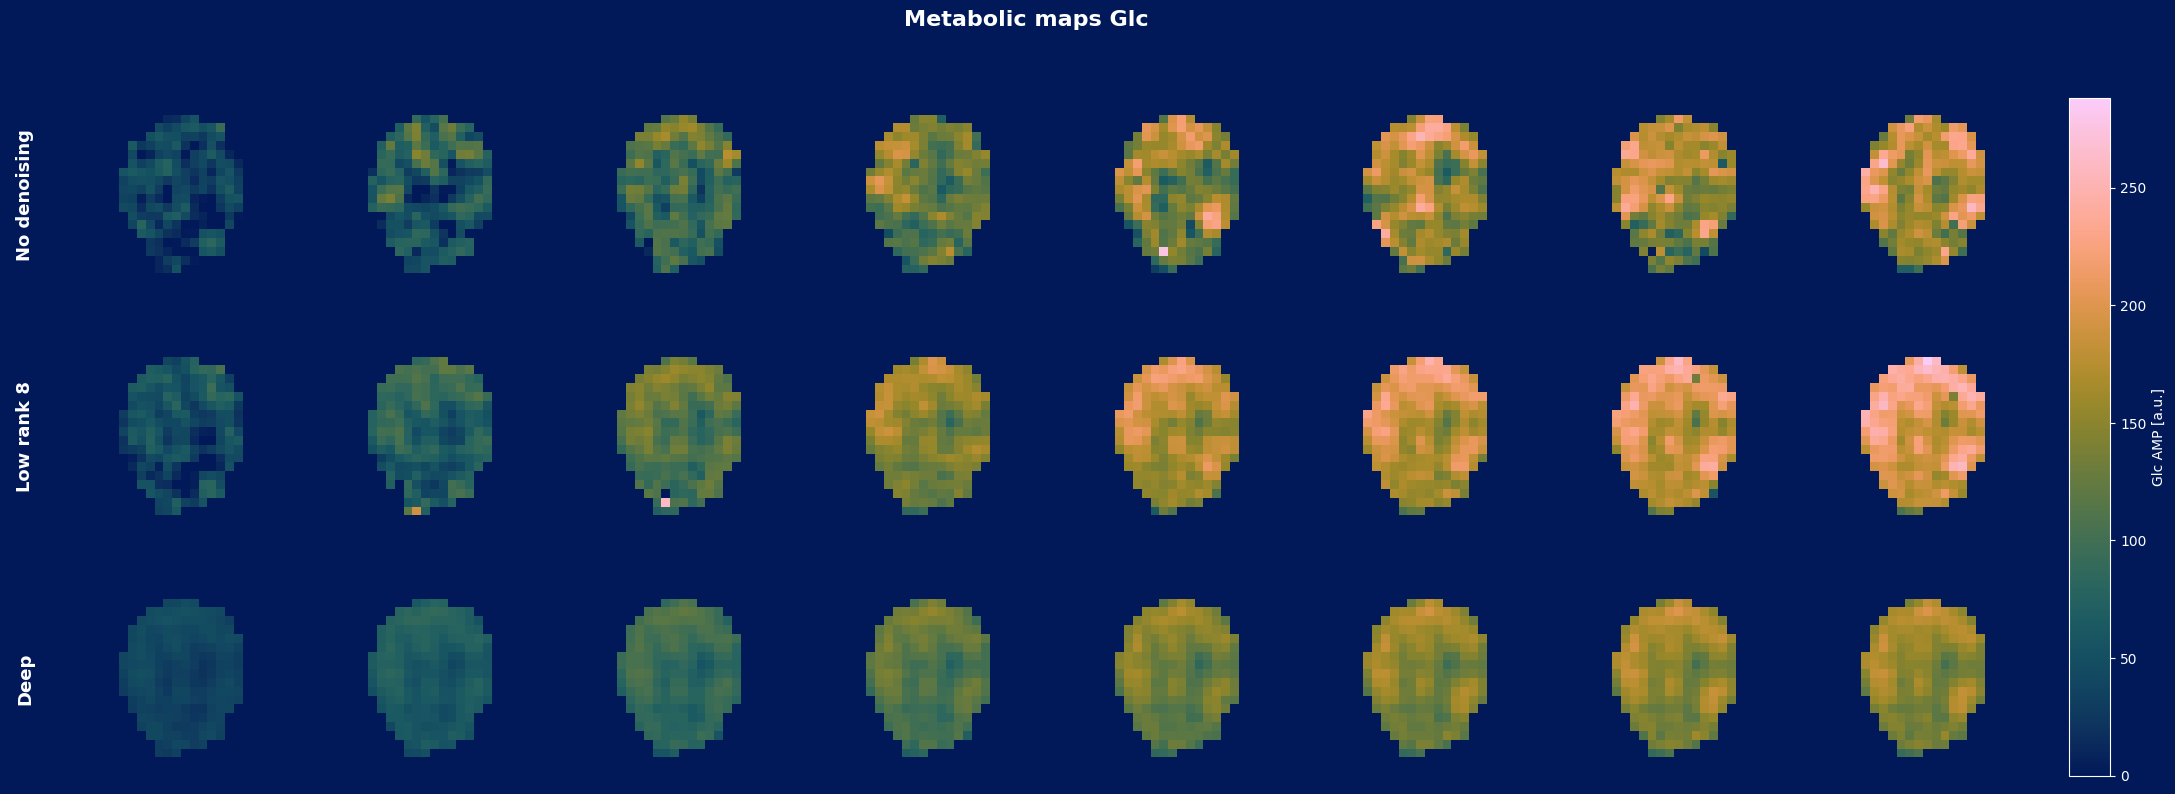

In [35]:
plot_metab_maps(
    metabolite='Glc',
    methods=COMPARISONS,
    quality_clip=False,
    outlier_clip=outlier_clip,
    clip_pct=clip_pct,  # entfernt oberste 2% der Fehlerpixel
    row_titles=["No denoising", "Low rank 8", "Deep"]  # deine gewünschten Zeilentitel
   # mask_file="mask.npy"   # deine Maske
)